In [1]:
from skimage import io,morphology,filters,color,transform,measure

# This image is got from given pdf (005.pdf ,Second page)

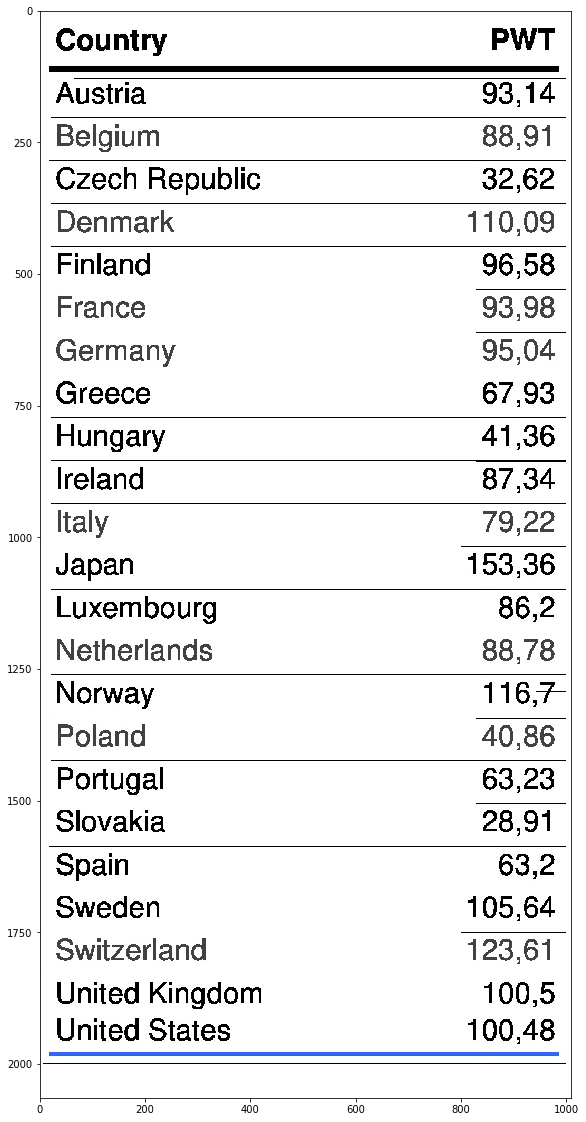

In [2]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20,20))

plt.imshow(io.imread("test-3.jpg"))

plt.show()

In [3]:
class BoundingBox(object):
    def __init__(self,contour):
        self.contour = contour
        y,x = zip(*contour)
        self.x1 = min(x)
        self.y1 = min(y)
        self.x2 = max(x)
        self.y2 = max(y)
    @property
    def h(self):
        return self.y2 - self.y1
    
    @property
    def w(self):
        return self.x2 - self.x1
    
    @property
    def area(self):
        return self.h * self.w
    
    @property
    def center(self):
        return (self.x1 + self.w // 2, self.y1+self.h//2)
    
    @property
    def plot(self):
        return (
        (self.x1,self.x2,self.x2,self.x1,self.x1),
        (self.y1,self.y1,self.y2,self.y2,self.y1),
        )
    
    @property
    def aspect(self):
        return self.h/self.w
    
    def project_y(self,y):
        copy = BoundingBox(self.contour)
        copy.y1 = y
        copy.y2 = y+self.h
        return copy
    
    def project_x(self,x):
        copy = BoundingBox(self.contour)
        copy.x1 = x
        copy.x2 = x + self.w
        return copy
    
    def __eq__(self,other):
        return self.x1 - 10 <= other.x1 <= self.x1 + 10 and self.y1 - 10 <= other.y1 <= self.y1 + 10
    
    def __repr__(self):
        return "BoundingBox ({},{},{},{})".format(self.x1,self.y1,self.x2,self.y2)

In [4]:
def morphed( im ,min_area=1024):
    im = threshold(im)
    k1 = morphology.rectangle(1,20)
    k2 = morphology.rectangle(40,1)
    return morphology.remove_small_objects(
        morphology.binary_opening(im,k1) | morphology.binary_opening(im,k2),
        min_area,
    )

In [5]:
def threshold(im):
    im = color.rgb2gray(im)
    im = im>filters.threshold_otsu(im)
    return ~im

In [6]:
image = io.imread("test-3.jpg")

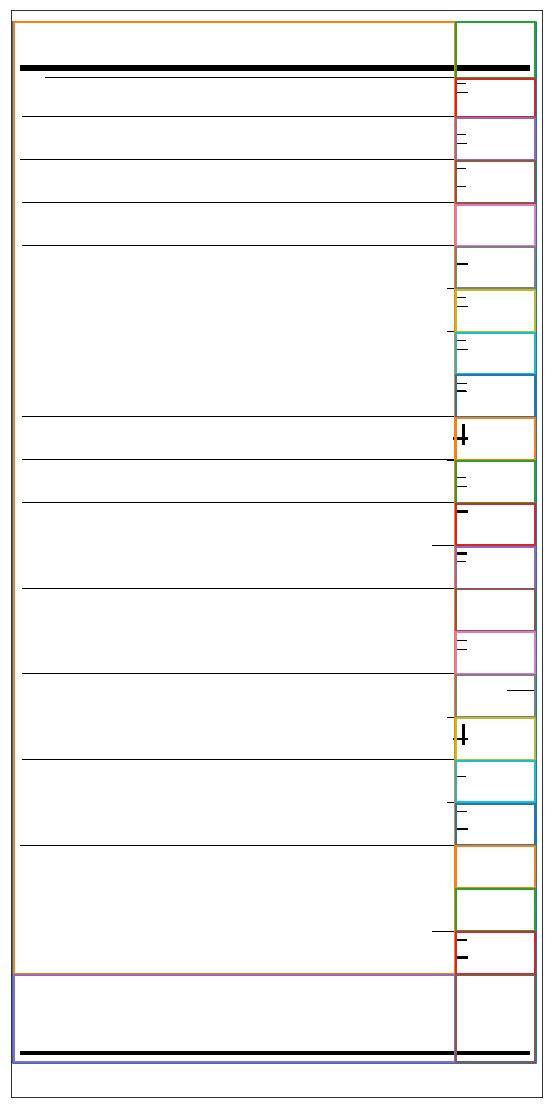

In [7]:
im = morphed(image)
fig,ax = plt.subplots(figsize=(20,20))
ax.imshow(~im,interpolation='nearest',cmap = plt.cm.gray)

contours = measure.find_contours(~im,0.8)

for contour in contours:
    ax.plot(*BoundingBox(contour).plot,linewidth=2)
    
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [8]:
def exclude_outliers(contours):
    bboxes = [BoundingBox(contour) for contour in contours]
    mean_area = np.mean([bbox.area for bbox in bboxes])
    return [bbox for bbox in bboxes if bbox.area < mean_area * 2 and 0.05 < bbox.aspect < 2]

In [9]:
def unique(bboxes):
    if len(bboxes)<2:
        return bboxes
    bboxes = sorted(bboxes,key=lambda x:x.area)
    unique = [bboxes.pop(0)]
    for bbox in bboxes:
        if any(bbox == _ for _ in unique):
            continue
        unique.append(bbox)
    return unique

In [10]:
def gridfy(bboxes):
    y1 = min(bbox.y1 for bbox in bboxes)
    x1 = min(bbox.x1 for bbox in bboxes)
    bboxes = sorted(bboxes,key = lambda x:x.area)
    horizontal = sorted(unique([bbox.project_y(y1) for bbox in bboxes]),key=lambda x:x.x1)
    vertical = sorted(unique([bbox.project_x(x1) for bbox in bboxes]),key = lambda x:x.y1)
    grid ={}
    for i,v in enumerate(vertical):
        for j,h in enumerate(horizontal):
            cell = h.project_y(v.y1)
            cells = [_ for _ in bboxes if _ == cell]
            if cells:
                grid[(i,j)] = cells[0]
    return grid

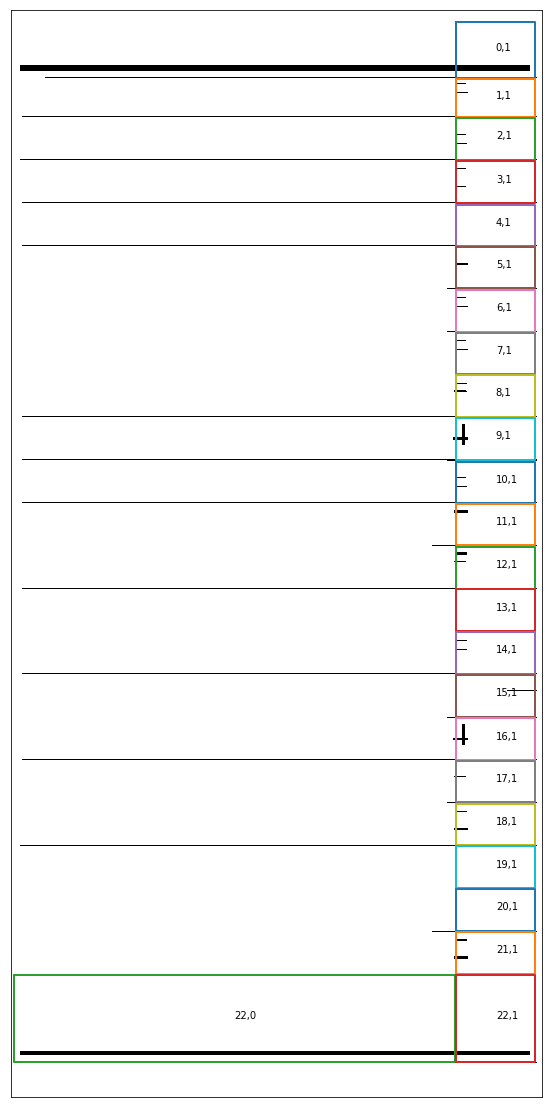

In [11]:
import numpy as np
im = morphed(image)
fig,ax = plt.subplots(figsize=(20,20))
ax.imshow (~im,interpolation='nearest',cmap = plt.cm.gray)
contours = measure.find_contours(~im,0.9)
cells = gridfy(exclude_outliers(contours))


for (line,column), bbox in cells.items():
    ax.plot(*bbox.plot, linewidth=2)
    ax.text(*bbox.center,"{},{}".format(line,column))
    
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [12]:
import tesserocr

import csv

In [13]:
from PIL import Image

from io import StringIO
from unidecode import unidecode

In [14]:
def cells_to_csv(image,cells,f):
    pil = Image.fromarray(image)
    ocr={}
    for (line,column),bbox in cells.items():
        extracted_text= (tesserocr.image_to_text(
            pil.crop(
                (bbox.x1,bbox.y1,bbox.x2,bbox.y2)
            ).resize(
                (int(bbox.w * 2),int(bbox.h * 2))
            )
        ))
        ocr[line,column] = extracted_text.strip()
        print(ocr[line,column])
        
    lines,columns = zip(*ocr)
    lines,columns = max(lines),max(columns)
    writer = csv.writer(f)
    writer.writerow([str(column) for column in range(1,columns+2)])
    for line in range(lines+1):
        row = [ocr.get((line,column),"") for column in range(columns+1)]
        writer.writerow([unidecode(_) for _ in row])
        
with open("output.csv",'w',newline='',encoding='utf-8') as f:
    cells_to_csv(image,cells,f)

PWT
J3,14
338,91
32,62
10,09
36,58
I3,98
95,04
37,93
41,36
37,34
19,22
93,36
86,2
38,78
116,7-
40,86
93,23
28,91

J5,64
23,61
United Kingdom
United States
100,5
J0,48


In [15]:
import petl as etl
etl.fromcsv("output.csv",encoding='iso-8859-1',errors='ignore')

1,2
,PWT
,"J3,14"
,"338,91"
,"32,62"
,"10,09"
